# Alex Net - Unlearn 

* **Author**: Mahanth Yalla
* **SR No** : 24004

### Image-net Validation dataset download

In [ ]:
import kagglehub
path = kagglehub.dataset_download("titericz/imagenet1k-val")
print("Path to dataset files:", path)

/scratch/kaifalam/anaconda3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 6.21G/6.21G [05:57<00:00, 18.7MB/s]  

Extracting files...


Path to dataset files: /home/kaifalam/.cache/kagglehub/datasets/titericz/imagenet1k-val/versions/1


In [6]:
path_new = './data/imagenet-val/'

## imports

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, Dataset

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import alexnet, AlexNet_Weights
from torch.utils.data import DataLoader
from tqdm import tqdm

import os
import tqdm
import math
import json
import pickle
import pynvml
import argparse
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime as dt
import matplotlib.gridspec as gridspec


In [ ]:
VAL_DIR = './data/imagenet-val' 
BATCH_SIZE = 64


def get_best_gpu(verbose = False):
    pynvml.nvmlInit()
    num_gpus = torch.cuda.device_count()

    if num_gpus == 0:
        if verbose :
            print("[!] No CUDA devices found, running on CPU.")
        return 'cpu'

    gpu_mem = []
    for i in range(num_gpus):
        handle = pynvml.nvmlDeviceGetHandleByIndex(i)
        mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
        free_mem = mem_info.free
        total_mem = mem_info.total
        if verbose:
            print(f"[+] GPU {i}: Total {total_mem / 1e9:.2f} GB, Free {free_mem / 1e9:.2f} GB")
        gpu_mem.append((i, free_mem))

    gpu_mem.sort(key=lambda x: x[1], reverse=True)

    best_gpu = gpu_mem[0][0]
    second_best_gpu = gpu_mem[1][0] if len(gpu_mem) > 1 else best_gpu

    selected_gpu = second_best_gpu if best_gpu == 0 else best_gpu

    pynvml.nvmlShutdown()
    return selected_gpu

def set_gpu(manual_set = None, verbose = False):
    device_active = 'cuda' if torch.cuda.is_available() else 'cpu'
    if device_active == 'cuda':
        if verbose:
            print('[+] CUDA : available')
        try:
            if manual_set is not None:
                GPU_NUMBER = manual_set
            else:
                GPU_NUMBER = get_best_gpu(verbose)
            if verbose:
                print(f'[>] Current Device {torch.cuda.current_device()} -> changing it to {GPU_NUMBER}')
            torch.cuda.set_device(GPU_NUMBER)
            if verbose:
                print(f'[+] Current Device {torch.cuda.current_device()}')
        except Exception as e:
            if verbose:
                print(f'[-] Error Occured while changing GPU ! \n\n\tERROR :{e}\n\n')
                print(f'[!] CUDA ERR : Couldn\'t change  -> using CPU {device_active = }')
        finally: 
            pass
        print(f'[>] device = cuda:{GPU_NUMBER}')
    else :
        if verbose:
            print(f'[!] CUDA ERR : Not available -> using CPU {device_active = }')
        print(f'[>] device = cpu')

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])


In [ ]:

val_dataset = ImageFolder(root=VAL_DIR, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

100%|██████████| 782/782 [02:02<00:00,  6.41it/s]


✅ Top-1 Accuracy: 56.55%
✅ Top-5 Accuracy: 79.09%


### Alex Net - Testing

In [ ]:
weights = AlexNet_Weights.IMAGENET1K_V1
model = alexnet(weights=weights).to(DEVICE)
model.eval()

In [ ]:

def evaluate_topk(model, dataloader, device, topk=(1, 5)):
    top1_correct = 0
    top5_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, pred_top5 = outputs.topk(max(topk), dim=1, largest=True, sorted=True)

            for i in range(images.size(0)):
                label = labels[i].item()
                top_preds = pred_top5[i]
                if label == top_preds[0].item():
                    top1_correct += 1
                if label in top_preds[:5]:
                    top5_correct += 1
                total += 1

    top1 = 100 * top1_correct / total
    top5 = 100 * top5_correct / total
    return top1, top5

In [ ]:

top1_acc, top5_acc = evaluate_topk(model, val_loader, DEVICE)
print(f"\nTop-1 Accuracy: {top1_acc:.2f}%")
print(f"Top-5 Accuracy: {top5_acc:.2f}%")


# Alex Net - Unlearn

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, Dataset

import os
import tqdm
import math
import json
import copy 
import pickle
import pynvml
import argparse
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime as dt
import matplotlib.gridspec as gridspec
from collections import defaultdict

In [ ]:

def classwise_accuracy(model, dataloader, device):
    model.eval()
    correct = defaultdict(int)
    total = defaultdict(int)

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            for pred, label in zip(preds, labels):
                total[int(label)] += 1
                if pred == label:
                    correct[int(label)] += 1
    return {cls: 100 * correct[cls] / total[cls] for cls in total}


In [ ]:
def record_layer_io_shapes(model, input_shape=(1, 3, 224, 224), device='cuda'):
    io_shapes = {}
    hooks = []

    def make_hook(name):
        def hook(module, input, output):
            io_shapes[name] = {
                'input': tuple(input[0].shape),
                'output': tuple(output.shape)
            }
        return hook

    model.eval().to(device)

    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Module):
            hooks.append(module.register_forward_hook(make_hook(name)))

    dummy_input = torch.randn(*input_shape).to(device)
    with torch.no_grad():
        model(dummy_input)

    for h in hooks:
        h.remove()
    return io_shapes

In [50]:
def generate_class_impression_from_activation(model, target_class, layer_name, init_mode='kaiming', num_steps=300, lr=0.1, device='cuda', verbose = False):
    model.eval().to(device)

    io_shapes = record_layer_io_shapes(model, device=device)
    if layer_name not in io_shapes:
        raise ValueError(f"Layer '{layer_name}' not found.")

    activation_shape = io_shapes[layer_name]['input']
    if verbose:
        print(f"[+] Shape of activation at input to '{layer_name}': {activation_shape}")

    act_tensor = torch.empty(activation_shape, requires_grad=True, device=device)
    if init_mode == 'kaiming':
        torch.nn.init.kaiming_normal_(act_tensor)
    elif init_mode == 'xavier':
        torch.nn.init.xavier_normal_(act_tensor)
    elif init_mode == 'normal':
        torch.nn.init.normal_(act_tensor, mean=0.0, std=0.02)
    else:
        raise ValueError(f"Unsupported init mode: {init_mode}")

    optimizer = torch.optim.Adam([act_tensor], lr=lr)

    found = False
    tail_layers = []
    for name, module in model.named_modules():
        if name == layer_name:
            found = True
        if found and isinstance(module, torch.nn.Module) and name != '':
            tail_layers.append(module)
    if not tail_layers:
        raise RuntimeError(f"No layers found after {layer_name} to build tail model.")

    tail_net = torch.nn.Sequential(*tail_layers).to(device)


    for step in range(num_steps):
        optimizer.zero_grad()
        output = tail_net(act_tensor)
        target_score = output[0, target_class]
        loss = -target_score
        loss.backward()
        optimizer.step()

        if step % 50 == 0 and verbose:
            print(f"[{step:03d}] Class {target_class} score: {target_score.item():.4f}")

    final_scores = tail_net(act_tensor)
    softmaxes = F.softmax(final_scores, dim=-1)
    max_ele = torch.argmax(softmaxes)
    if verbose :
        print(f'{softmaxes = }\n{max_ele = }')
    
    return act_tensor.detach(), activation_shape , max_ele.item()



In [51]:
alexnet_model = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
layer_sizes = record_layer_io_shapes(alexnet_model, input_shape=(1, 3, 224, 224))
print(layer_sizes.keys())

dict_keys(['features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features', 'avgpool', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6', 'classifier', ''])


In [ ]:
def get_learnable_layers(model, responsive_layers):
    learnable_layers = []

    for layer_name in responsive_layers:
        has_params = False
        for name, param in model.named_parameters():
            if layer_name in name and param.requires_grad and param.numel() > 0:
                has_params = True
                break
        if has_params:
            learnable_layers.append(layer_name)
        else:
            print(f"[⏭] Skipping non-learnable layer: {layer_name}")
    
    return learnable_layers

In [54]:
import matplotlib.pyplot as plt
import numpy as np

def plot_accuracy_diff(acc_before, acc_after, class_idx_to_name):
    classes = sorted(acc_before.keys())
    diffs = [acc_after.get(cls, 0) - acc_before.get(cls, 0) for cls in classes]

    colors = ['green' if d >= 0 else 'red' for d in diffs]
    names = [class_idx_to_name.get(cls, str(cls)) for cls in classes]

    plt.figure(figsize=(20, 6))
    bars = plt.bar(range(len(classes)), diffs, color=colors)
    plt.axhline(0, color='black', linewidth=0.8)
    plt.title("Change in Class-wise Accuracy After Unlearning")
    plt.xlabel("Class")
    plt.ylabel("Accuracy Change (%)")
    plt.xticks(range(len(classes)), names, rotation=90)
    plt.tight_layout()
    plt.show()


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
acc_before = classwise_accuracy(model, val_loader, device)

In [56]:
class ImpressionDataset(Dataset):
    def __init__(self, data_tensor):
        self.data = data_tensor
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, idx):
        return self.data[idx]


In [57]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [58]:
layer_names = list(layer_sizes.keys())[:-1]
layer_names

['features.0',
 'features.1',
 'features.2',
 'features.3',
 'features.4',
 'features.5',
 'features.6',
 'features.7',
 'features.8',
 'features.9',
 'features.10',
 'features.11',
 'features.12',
 'features',
 'avgpool',
 'classifier.0',
 'classifier.1',
 'classifier.2',
 'classifier.3',
 'classifier.4',
 'classifier.5',
 'classifier.6',
 'classifier']

In [61]:
first_responsive_layer = 'classifier.6'

In [ ]:
net_name = 'AlexNet'
version_name = 'v1_fine'
directory = f'./models/{net_name}_{version_name}'
if not os.path.exists(directory):
    os.makedirs(directory)

In [63]:
os.makedirs(f'{directory}/class_impressions/',exist_ok=True)

In [ ]:
def generate_class_impression_dataset(model, target_class, layer_name,  num_samples=500, init_mode='kaiming', num_steps=300, lr=0.1, device='cuda'):
    all_activations = []
    eps = 1e-9
    while len(all_activations) < num_samples:
        impression, shape, max_ele = generate_class_impression_from_activation(model, target_class=target_class, layer_name=layer_name, init_mode=init_mode, num_steps=num_steps, lr=lr, device = device)
        if max_ele == target_class:
            for s in all_activations:
                if torch.norm(s - impression) < eps:
                    break
            else:
                all_activations.append(impression)

    stacked_tensor = torch.cat(all_activations, dim=0)
    save_path = f'{directory}/class_impressions/{layer_name}_class_{target_class}_{num_samples}.pt'
    torch.save(stacked_tensor, save_path)
    
    return save_path

def generate_class_impression(model, target_class, layer_name, directory,  num_samples=500, init_mode='kaiming', num_steps=300, lr=0.1, device='cuda'):
    save_path = f'{directory}/class_impressions/{layer_name}_class_{target_class}_{num_samples}.pt'
    if os.path.exists(save_path):
        print(f"[!] Class impression dataset for class {target_class} and layer {layer_name} already exists.")
        return save_path
    all_activations = []
    eps = 1e-9
    while len(all_activations) < num_samples:
        impression, shape, max_ele = generate_class_impression_from_activation(model, target_class=target_class, layer_name=layer_name, init_mode=init_mode, num_steps=num_steps, lr=lr, device = device)
        if max_ele == target_class:
            for s in all_activations:
                if torch.norm(s - impression) < eps:
                    break
            else:
                all_activations.append(impression)

    stacked_tensor = torch.cat(all_activations, dim=0)
    torch.save(stacked_tensor, save_path)
    
    return save_path

def generate_cis_for_all_classes(labels, model, layer_name, directory, num_samples=500, init_mode='kaiming', num_steps=300, lr=0.1, device='cuda'):
    paths = {}
    for cls in list(labels):    
        paths[cls] = generate_class_impression(
            model=model,
            target_class=cls,
            layer_name=layer_name,
            directory=directory,
            num_samples=num_samples,
            init_mode=init_mode,
            num_steps=num_steps,
            lr=lr,
            device=device 
        )
        print(f'[+] {cls = } {paths[cls] = }')
    return paths 


In [72]:
labels = np.arange(1000)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
TARGET_CLS = 7

net_name = 'AlexNet'
version_name = 'v1_fine'
directory = f'./models/{net_name}_{version_name}'

ci_dir = f'{directory}/class_impressions'
os.makedirs(ci_dir, exist_ok=True)

In [74]:
NUM_SAMPLES = 25
LAYER_NAME = first_responsive_layer
INIT_MODE = 'xavier'
STEPS_PER_SAMPLE = 250
LEARN_RATE = 0.1

paths_cis = generate_cis_for_all_classes(
    labels = labels,
    model  = model,
    directory = directory,
    layer_name=LAYER_NAME,
    num_samples=NUM_SAMPLES,
    init_mode=INIT_MODE,
    num_steps=STEPS_PER_SAMPLE,
    lr=LEARN_RATE,
    device=device ,
)
print(paths_cis)

[+] cls = np.int64(0) paths[cls] = './models/AlexNet_v1_fine/class_impressions/classifier.6_class_0_25.pt'
[+] cls = np.int64(1) paths[cls] = './models/AlexNet_v1_fine/class_impressions/classifier.6_class_1_25.pt'
[+] cls = np.int64(2) paths[cls] = './models/AlexNet_v1_fine/class_impressions/classifier.6_class_2_25.pt'
[+] cls = np.int64(3) paths[cls] = './models/AlexNet_v1_fine/class_impressions/classifier.6_class_3_25.pt'
[+] cls = np.int64(4) paths[cls] = './models/AlexNet_v1_fine/class_impressions/classifier.6_class_4_25.pt'
[+] cls = np.int64(5) paths[cls] = './models/AlexNet_v1_fine/class_impressions/classifier.6_class_5_25.pt'
[+] cls = np.int64(6) paths[cls] = './models/AlexNet_v1_fine/class_impressions/classifier.6_class_6_25.pt'
[+] cls = np.int64(7) paths[cls] = './models/AlexNet_v1_fine/class_impressions/classifier.6_class_7_25.pt'
[+] cls = np.int64(8) paths[cls] = './models/AlexNet_v1_fine/class_impressions/classifier.6_class_8_25.pt'
[+] cls = np.int64(9) paths[cls] = '.

In [75]:
def get_class_impression_paths(directory, layer_name, num_samples):
    imp_folder = f'{directory}/class_impressions/'
    paths_ = os.listdir(imp_folder)
    paths = {}
    for p in paths_:
        k = p.split('_')
        cls = int(k[-2])
        num_samp = int(k[-1].split('.')[0])
        layer = k[0]
        if num_samp == num_samples and layer == layer_name:
            paths[cls] = f'{imp_folder}{p}'
    return paths
    

directory = f'./models/{net_name}_{version_name}'
layer_name = first_responsive_layer
num_samples = NUM_SAMPLES
paths = get_class_impression_paths(directory, layer_name, num_samples)
print(paths[0] , len(paths)) 


./models/AlexNet_v1_fine/class_impressions/classifier.6_class_0_25.pt 1000


In [ ]:
def get_datasets_from_paths(paths, target_classes, labels = labels):
    retain_impressions = []
    retain_y = []
    forget_impressions = []
    forget_y = []
    for cls in list(labels):
        repeated_cls = torch.ones(NUM_SAMPLES , dtype = torch.long , device = device) * cls
        cls_impressions = torch.load(paths[cls]).to(device)
        if cls in target_classes:
            forget_impressions.append(cls_impressions)
            forget_y.append(repeated_cls)
        else :
            retain_impressions.append(cls_impressions)
            retain_y.append(repeated_cls)
            
    X_forget = torch.cat(forget_impressions)
    X_retain = torch.cat(retain_impressions)
    y_forget = torch.cat(forget_y)
    y_retain = torch.cat(retain_y)

    return X_forget, y_forget, X_retain, y_retain

## randomly handpicked classes
target_classes = {10,20,30,39,44,56,111,124, 
                  211,222,267,263,
                    313,334,375,396,
                    424,425,456,477,
                    525,546,557,568,
                    616,637,668,699,
                    717,728,749,780,
                    828,849,870,891,
                    929, 935, 976, 988
                  }
print(f'{len(target_classes) = }')

X_forget, y_forget, X_retain, y_retain = get_datasets_from_paths(paths , target_classes)
print(f'{X_forget.shape = }\t{y_forget.shape = }')
print(f'{X_retain.shape = }\t{y_retain.shape = }')

len(target_classes) = 40
X_forget.shape = torch.Size([1000, 4096])	y_forget.shape = torch.Size([1000])
X_retain.shape = torch.Size([24000, 4096])	y_retain.shape = torch.Size([24000])


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
from tqdm import tqdm

class ZeroShotUnlearner:
    def __init__(self, model, forget_loader, retain_loader,
                 first_responsive_layer_string,
                 forget_loss_weight=0.9, retain_loss_weight=0.1,
                 lr=1e-4, device='cuda', clip_grad=5.0):
        self.device = device
        self.model = model.to(device)
        self.forget_loader = forget_loader
        self.retain_loader = retain_loader
        self.forget_loss_weight = forget_loss_weight
        self.retain_loss_weight = retain_loss_weight
        self.clip_grad = clip_grad

        self.tail_model = self._get_tail_model(first_responsive_layer_string).to(device)

        self._freeze_before(first_responsive_layer_string)

        self.optimizer = optim.AdamW(self.tail_model.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)


    def _get_tail_model(self, layer_string):
        modules = []
        include = False
        for name, module in self.model.named_modules():
            if name == layer_string:
                include = True
                modules = [module]  
                break
        if not modules:
            raise ValueError(f"[-] No module named '{layer_string}' found.")
        return nn.Sequential(*modules)


    def _freeze_before(self, layer_string):
        freeze = True
        for name, param in self.model.named_parameters():
            if freeze:
                param.requires_grad = False
            if layer_string in name:
                freeze = False
        print(f"[+] Frozen layers before and including: {layer_string}")

    def unlearn(self, epochs=10, verbose = False):
        self.model.eval()
        self.tail_model.train()

        for ep in tqdm(range(epochs) , desc = 'Unlearning'):
            total_f_loss, total_r_loss = 0.0, 0.0

            for x_f, y_f in self.forget_loader:
                x_f, y_f = x_f.to(self.device), y_f.to(self.device)
                out_f = self.tail_model(x_f)
                loss_f = self.criterion(out_f, y_f)

                loss =  self.forget_loss_weight * loss_f

                self.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(self.tail_model.parameters(), self.clip_grad)
                self.optimizer.step()

                total_f_loss += loss_f.item()

            for x_r, y_r in self.retain_loader:
                x_r, y_r = x_r.to(self.device), y_r.to(self.device)
                out_r = self.tail_model(x_r)
                loss_r = self.criterion(out_r, y_r)

                loss = - self.retain_loss_weight * loss_r
                
                self.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(self.tail_model.parameters(), self.clip_grad)
                self.optimizer.step()

                total_r_loss += loss_r.item()
            if verbose and (ep+1) % 10 == 0:
                print(f"Epoch [{ep+1:5d}/{epochs:5d}] | Forget Loss: {total_f_loss:.6f} | Retain Loss: {total_r_loss:.6f}")

        return self.tail_model

u_model = copy.deepcopy(model)
BATCH_SIZE = 16
X_forget_dataset = torch.utils.data.TensorDataset(X_forget, y_forget)
X_retain_dataset = torch.utils.data.TensorDataset(X_retain, y_retain)
print(f'{len(X_forget_dataset) = }, {len(X_retain_dataset) = }')
print(f'{first_responsive_layer = }')

unlearner = ZeroShotUnlearner(
    u_model, 
    first_responsive_layer_string= first_responsive_layer,
    forget_loader= torch.utils.data.DataLoader(X_forget_dataset, batch_size=BATCH_SIZE, shuffle=True),
    retain_loader= torch.utils.data.DataLoader(X_retain_dataset, batch_size=BATCH_SIZE, shuffle=True),
    lr = 1e-3,
    forget_loss_weight=0.9, 
    retain_loss_weight=0.1,
    device=device,
)   

tail_model = unlearner.unlearn(epochs=1000)

len(X_forget_dataset) = 1000, len(X_retain_dataset) = 24000
first_responsive_layer = 'classifier.6'
✅ Frozen layers before and including: classifier.6


Unlearning: 100%|██████████| 100/100 [03:26<00:00,  2.07s/it]


In [ ]:
import json
import urllib.request

url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
urllib.request.urlretrieve(url, "imagenet_class_index.json")
with open("imagenet_class_index.json") as f:
    idx_to_info = json.load(f)

idx_to_wnid = {int(k): v[0] for k, v in idx_to_info.items()}  
idx_to_name = {int(k): v[1] for k, v in idx_to_info.items()} 
class_idx_to_name = idx_to_name

('imagenet_class_index.json', <http.client.HTTPMessage at 0x7f49eedac3d0>)

100%|██████████| 782/782 [01:13<00:00, 10.68it/s]


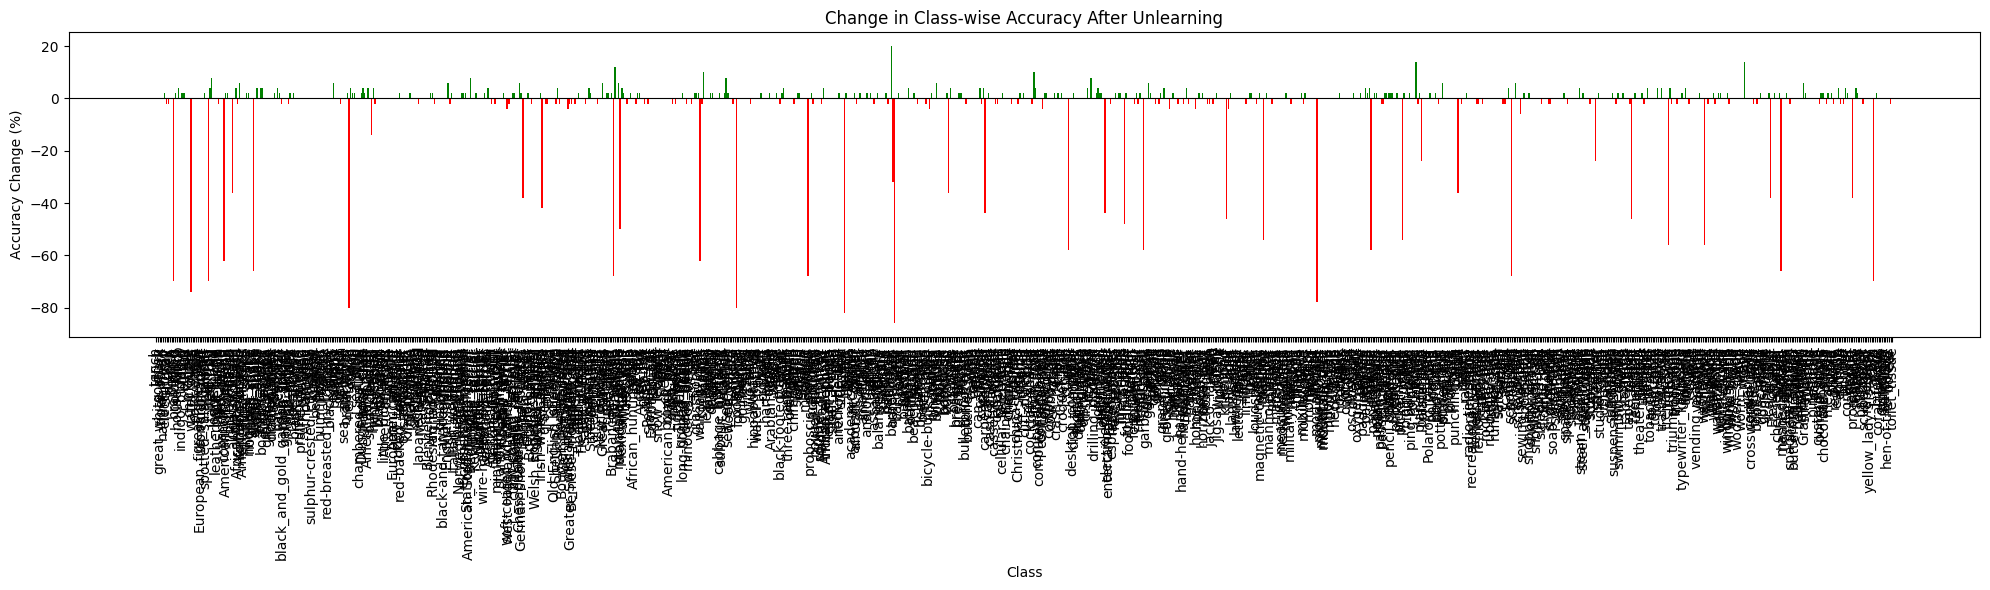

In [87]:
acc_after = classwise_accuracy(u_model, val_loader, device)
plot_accuracy_diff(acc_before, acc_after, class_idx_to_name)

In [ ]:
import pandas as pd

def accuracy_comparison_table(acc1, acc2, idx_to_name):
    data = []
    for cls in acc1:
        old = acc1[cls]
        new = acc2.get(cls, 0)
        change = new - old
        data.append({
            'Class Index': cls,
            'Class Name': idx_to_name.get(str(cls), f'class_{cls}'),
            'Original Acc': old,
            'Unlearned Acc': new,
            'Δ Accuracy': change
        })
    df = pd.DataFrame(data).sort_values(by='Δ Accuracy')
    return df

table = accuracy_comparison_table(acc_before, acc_after, class_idx_to_name)
table.head(10)

     Class Index Class Name  Original Acc  Unlearned Acc  Δ Accuracy
425          425  class_425          86.0            0.0       -86.0
396          396  class_396          86.0            4.0       -82.0
334          334  class_334          80.0            0.0       -80.0
111          111  class_111          82.0            2.0       -80.0
668          668  class_668          78.0            0.0       -78.0
20            20   class_20          76.0            2.0       -74.0
10            10   class_10          78.0            8.0       -70.0
30            30   class_30          70.0            0.0       -70.0
988          988  class_988          70.0            0.0       -70.0
780          780  class_780          68.0            0.0       -68.0


In [89]:
overall_accuracy_before = sum(acc_before.values()) / len(acc_before)
overall_accuracy_after = sum(acc_after.values()) / len(acc_after)
print(f"Overall Accuracy Before Unlearning: {overall_accuracy_before:.2f}%")
print(f"Overall Accuracy After Unlearning: {overall_accuracy_after:.2f}%")

Overall Accuracy Before Unlearning: 56.55%
Overall Accuracy After Unlearning: 54.77%


In [ ]:
forget_class_table = table[table['Class Index'].isin(target_classes)]
retain_class_table = table[~table['Class Index'].isin(target_classes)]

avg_unlearned_acc_forget = forget_class_table['Unlearned Acc'].mean()
avg_unlearned_acc_retain = retain_class_table['Unlearned Acc'].mean()

print(f"Average Unlearned Accuracy for Forget Classes: {avg_unlearned_acc_forget:.2f}%")
print(f"Average Unlearned Accuracy for Retain Classes: {avg_unlearned_acc_retain:.2f}%")

Average Unlearned Accuracy for Forget Classes: 0.60%
Average Unlearned Accuracy for Retain Classes: 57.03%


# Better Visualizing - Unlearn

In [92]:
# first 50 classes and middle 390 to 440 and last 50 classes
target_classes = np.concatenate([
    np.arange(0, 50),
    np.arange(390, 440),
    np.arange(950, 1000)
])

target_classes = set(target_classes)
len(target_classes)

150

In [93]:
X_forget, y_forget, X_retain, y_retain = get_datasets_from_paths(paths , target_classes)
print(f'{X_forget.shape = }\t{y_forget.shape = }')
print(f'{X_retain.shape = }\t{y_retain.shape = }')

X_forget.shape = torch.Size([3750, 4096])	y_forget.shape = torch.Size([3750])
X_retain.shape = torch.Size([21250, 4096])	y_retain.shape = torch.Size([21250])


In [95]:
u_model_v2 = copy.deepcopy(model)
BATCH_SIZE = 16

X_forget_dataset = torch.utils.data.TensorDataset(X_forget, y_forget)
X_retain_dataset = torch.utils.data.TensorDataset(X_retain, y_retain)

print(f'{len(X_forget_dataset) = }, {len(X_retain_dataset) = }')
print(f'{first_responsive_layer = }')

len(X_forget_dataset) = 3750, len(X_retain_dataset) = 21250
first_responsive_layer = 'classifier.6'


In [96]:
unlearner = ZeroShotUnlearner(
    u_model_v2, 
    first_responsive_layer_string= first_responsive_layer,
    forget_loader= torch.utils.data.DataLoader(X_forget_dataset, batch_size=BATCH_SIZE, shuffle=True),
    retain_loader= torch.utils.data.DataLoader(X_retain_dataset, batch_size=BATCH_SIZE, shuffle=True),
    lr = 1e-3,
    forget_loss_weight=0.9, 
    retain_loss_weight=0.1,
    device=device,
)   

tail_model = unlearner.unlearn(epochs=100)

✅ Frozen layers before and including: classifier.6


Unlearning: 100%|██████████| 100/100 [03:39<00:00,  2.20s/it]


In [97]:
acc_after_v2 = classwise_accuracy(u_model_v2, val_loader, device)

100%|██████████| 782/782 [01:51<00:00,  7.02it/s]


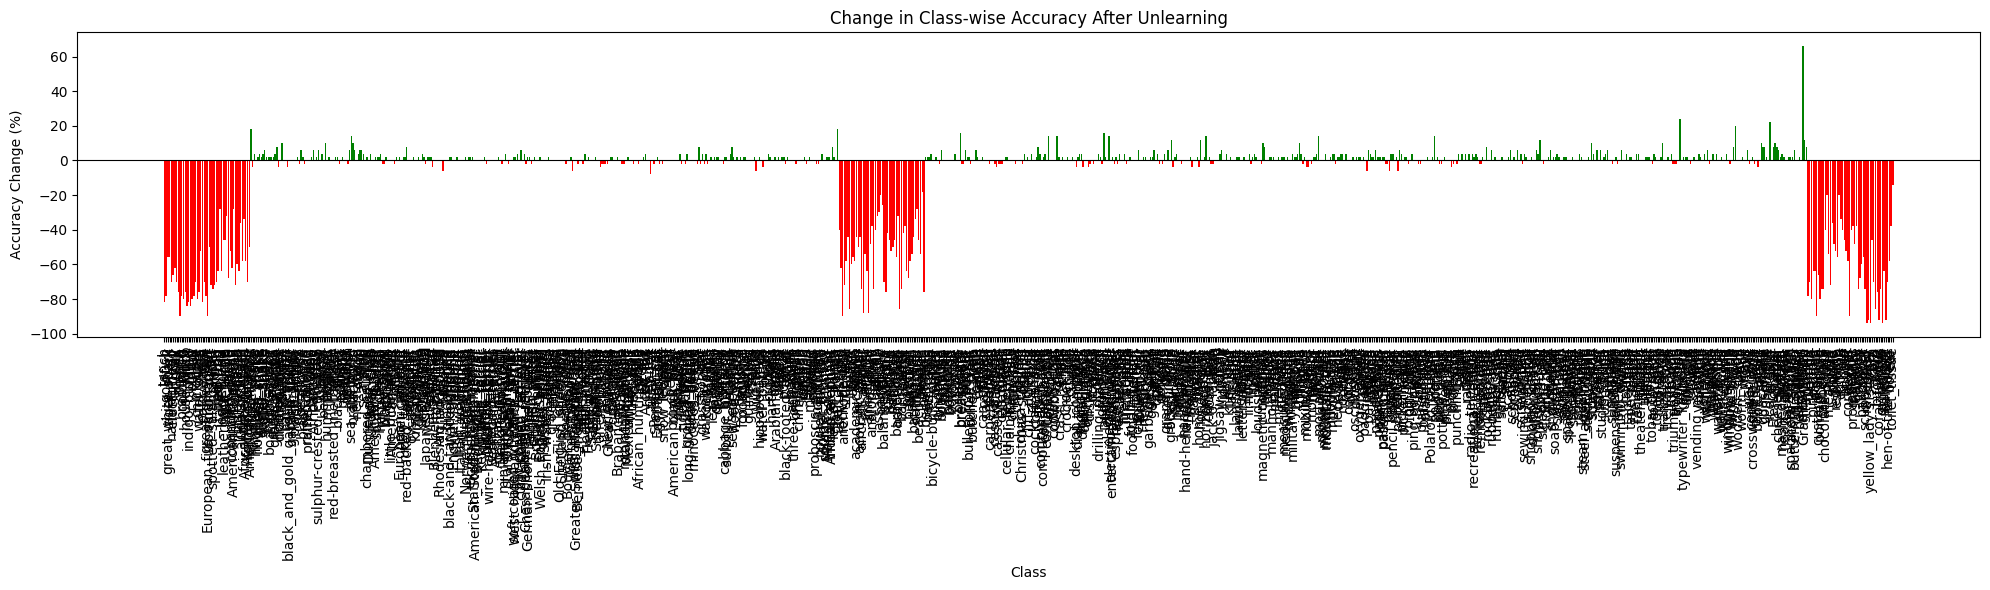

In [98]:
plot_accuracy_diff(acc_before, acc_after_v2, class_idx_to_name)

In [99]:
overall_accuracy_before = sum(acc_before.values()) / len(acc_before)
overall_accuracy_after = sum(acc_after_v2.values()) / len(acc_after_v2)
print(f"Overall Accuracy Before Unlearning: {overall_accuracy_before:.2f}%")
print(f"Overall Accuracy After Unlearning: {overall_accuracy_after:.2f}%")

table = accuracy_comparison_table(acc_before, acc_after_v2, class_idx_to_name)
forget_class_table = table[table['Class Index'].isin(target_classes)]
retain_class_table = table[~table['Class Index'].isin(target_classes)]

avg_unlearned_acc_forget = forget_class_table['Unlearned Acc'].mean()
avg_unlearned_acc_retain = retain_class_table['Unlearned Acc'].mean()

print(f"\nAverage Unlearned Accuracy for Forget Classes: {avg_unlearned_acc_forget:.2f}%")
print(f"Average Unlearned Accuracy for Retain Classes: {avg_unlearned_acc_retain:.2f}%")

Overall Accuracy Before Unlearning: 56.55%
Overall Accuracy After Unlearning: 48.62%

Average Unlearned Accuracy for Forget Classes: 0.17%
Average Unlearned Accuracy for Retain Classes: 57.17%


In [100]:
table.head(10)

,Class Index,Class Name,Original Acc,Unlearned Acc,Δ Accuracy
986,986,class_986,100.0,6.0,-94.0
993,993,class_993,96.0,2.0,-94.0
984,984,class_984,94.0,0.0,-94.0
985,985,class_985,92.0,0.0,-92.0
991,991,class_991,92.0,0.0,-92.0
995,995,class_995,92.0,0.0,-92.0
9,9,class_9,90.0,0.0,-90.0
25,25,class_25,90.0,0.0,-90.0
974,974,class_974,90.0,0.0,-90.0
955,955,class_955,90.0,0.0,-90.0


### Train more epochs ? 

len(X_forget_dataset) = 3750, len(X_retain_dataset) = 21250
first_responsive_layer = 'classifier.6'
✅ Frozen layers before and including: classifier.6


100%|██████████| 782/782 [01:08<00:00, 11.44it/s]


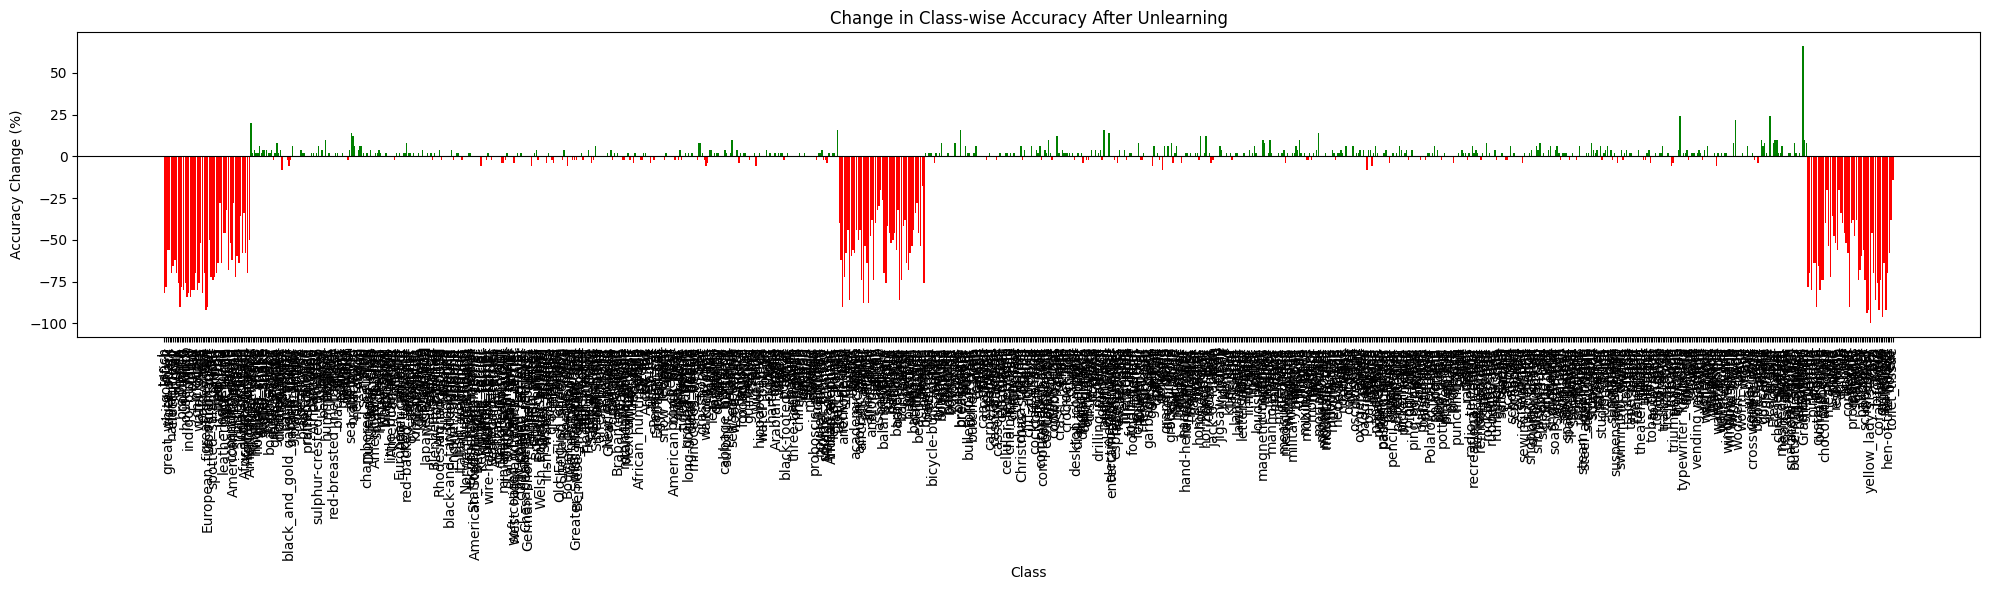

Overall Accuracy Before Unlearning: 56.55%
Overall Accuracy After Unlearning: 48.55%


,Class Index,Class Name,Original Acc,Unlearned Acc,Δ Accuracy
986,986,class_986,100.0,0.0,-100.0
993,993,class_993,96.0,0.0,-96.0
984,984,class_984,94.0,0.0,-94.0
24,24,class_24,94.0,2.0,-92.0
985,985,class_985,92.0,0.0,-92.0
995,995,class_995,92.0,0.0,-92.0
991,991,class_991,92.0,0.0,-92.0
9,9,class_9,90.0,0.0,-90.0
955,955,class_955,90.0,0.0,-90.0
974,974,class_974,90.0,0.0,-90.0



Average Unlearned Accuracy for Forget Classes: 0.01%
Average Unlearned Accuracy for Retain Classes: 57.11%


In [101]:
u_model_v3 = copy.deepcopy(model)
BATCH_SIZE = 16

X_forget_dataset = torch.utils.data.TensorDataset(X_forget, y_forget)
X_retain_dataset = torch.utils.data.TensorDataset(X_retain, y_retain)

print(f'{len(X_forget_dataset) = }, {len(X_retain_dataset) = }')
print(f'{first_responsive_layer = }')

unlearner = ZeroShotUnlearner(
    u_model_v3, 
    first_responsive_layer_string= first_responsive_layer,
    forget_loader= torch.utils.data.DataLoader(X_forget_dataset, batch_size=BATCH_SIZE, shuffle=True),
    retain_loader= torch.utils.data.DataLoader(X_retain_dataset, batch_size=BATCH_SIZE, shuffle=True),
    lr = 1e-3,
    forget_loss_weight=0.9, 
    retain_loss_weight=0.1,
    device=device,
)   

tail_model = unlearner.unlearn(epochs=1000)

acc_after_v3 = classwise_accuracy(u_model_v3, val_loader, device)

plot_accuracy_diff(acc_before, acc_after_v3, class_idx_to_name)

overall_accuracy_before = sum(acc_before.values()) / len(acc_before)
overall_accuracy_after = sum(acc_after_v3.values()) / len(acc_after_v3)
print(f"Overall Accuracy Before Unlearning: {overall_accuracy_before:.2f}%")
print(f"Overall Accuracy After Unlearning: {overall_accuracy_after:.2f}%")

table_v3= accuracy_comparison_table(acc_before, acc_after_v3, class_idx_to_name)

table_v3.head(10)

forget_class_table_v3 = table_v3[table_v3['Class Index'].isin(target_classes)]
retain_class_table_v3 = table_v3[~table_v3['Class Index'].isin(target_classes)]

avg_unlearned_acc_forget_v3 = forget_class_table_v3['Unlearned Acc'].mean()
avg_unlearned_acc_retain_v3 = retain_class_table_v3['Unlearned Acc'].mean()

print(f"\nAverage Unlearned Accuracy for Forget Classes: {avg_unlearned_acc_forget_v3:.2f}%")
print(f"Average Unlearned Accuracy for Retain Classes: {avg_unlearned_acc_retain_v3:.2f}%")